In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from catboost import CatBoostRegressor
import joblib

import warnings
warnings.filterwarnings('ignore')


In [199]:
df = pd.read_csv("cleaned_data.csv")

print(df.shape)
df.head()


(137, 9)


,country,region,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption
0,Finland,Western Europe,7.804,1.888,1.585,0.535,0.772,0.126,0.535
1,Denmark,Western Europe,7.586,1.949,1.548,0.537,0.734,0.208,0.525
2,Iceland,Western Europe,7.530,1.926,1.620,0.559,0.738,0.250,0.187
3,Israel,Middle East and North Africa,7.473,1.833,1.521,0.577,0.569,0.124,0.158
4,Netherlands,Western Europe,7.403,1.942,1.488,0.545,0.672,0.251,0.394


Feature selection


In [200]:
y=df[["happiness_score"]]
x=df.drop(["happiness_score", "country"],axis=1)

In [201]:
X_encoded = pd.get_dummies(x, columns=["region"])

In [202]:
x_train, x_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=30, random_state=50
)

In [203]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((107, 16), (30, 16), (107, 1), (30, 1))

## Linear Regression Model


In [204]:
linreg_model = LinearRegression()
linreg_model.fit(x_train, y_train)
linreg_model.coef_

array([[ 0.82658004,  0.96807338, -0.05238589,  1.75634801,  0.84174997,
         0.60470318,  0.08791283, -0.0142819 ,  0.04293731,  0.29436448,
        -0.18092108,  0.46892198, -0.63732238, -0.34471094, -0.16615832,
         0.44925801]])

In [205]:
arr = [0.82850578, 1.32640443, 0.43767883, 1.82244477, 0.68032134, 0.84192323]
pd.DataFrame([x.columns,arr])

,0,1,2,3,4,5,6
0,region,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption
1,0.828506,1.326404,0.437679,1.822445,0.680321,0.841923,None


In [206]:

linreg_preds = linreg_model.predict(x_test)
#to evaluate the model
linreg_r2 = r2_score(y_test, linreg_preds)
linreg_rmse = mean_squared_error(y_test, linreg_preds, squared=False)
linreg_mse=mean_squared_error(y_test,pred_test)

print("Linear Regression (numeric features only):")
print("R² Score:", linreg_r2)
print("RMSE:", linreg_rmse)
print("MSE:", linreg_mse)

Linear Regression (numeric features only):
R² Score: 0.7964262286883588
RMSE: 0.5244158988697367
MSE: 0.286872468466798


In [207]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

rf_preds = rf_model.predict(x_test)
#to evaluate the model
rf_r2 = r2_score(y_test, rf_preds)
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)
rf_mse = mean_squared_error(y_test, rf_preds)

print("Random Forest Regressor:")
print("R² Score:", rf_r2)
print("RMSE:", rf_rmse)
print("MSE:", rf_mse)

Random Forest Regressor:
R² Score: 0.7988715785649634
RMSE: 0.5212567132037726
MSE: 0.27170856106000013


In [208]:
# Compare models in a table
import pandas as pd

results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "R² Score": [linreg_r2, rf_r2],
    "RMSE": [linreg_rmse, rf_rmse],
    "MSE": [linreg_mse, rf_mse]
})

print(results)


               Model  R² Score      RMSE       MSE
0  Linear Regression  0.796426  0.524416  0.286872
1      Random Forest  0.798872  0.521257  0.271709


In [209]:
rf_scores = cross_val_score(rf_model, x_train, y_train, cv=5,
                            scoring="neg_root_mean_squared_error")
print("Random Forest CV RMSE:", -rf_scores.mean())

lin_scores = cross_val_score(linreg_model, x_train, y_train, cv=5,
                             scoring="neg_root_mean_squared_error")
print("Linear Regression CV RMSE:", -lin_scores.mean())


Random Forest CV RMSE: 0.5686457462297405
Linear Regression CV RMSE: 0.4965859066933881


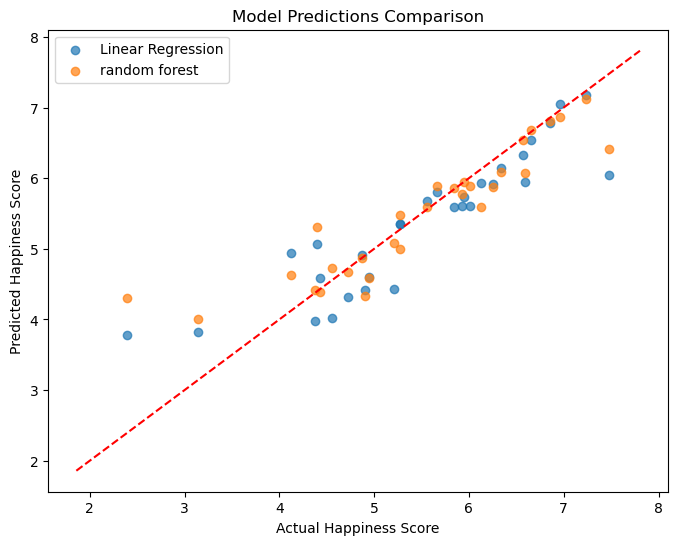

In [210]:
# Compare Linear Regression vs random forest visually
plt.figure(figsize=(8,6))
plt.scatter(y_test, linreg_preds, label="Linear Regression", alpha=0.7)
plt.scatter(y_test, rf_model.predict(x_test), label="random forest", alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Happiness Score")
plt.ylabel("Predicted Happiness Score")
plt.title("Model Predictions Comparison")
plt.legend()
plt.show()

In [197]:
# Choose the better model (lower RMSE, higher R²)
best_model = rf_model if rf_rmse < linreg_rmse else linreg_model



with open("final_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Step 11: Save training columns for Streamlit input alignment
training_columns = X_encoded.columns.tolist()
with open("training_columns_2023.pkl", "wb") as f:
    pickle.dump(training_columns, f)